In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_data_S9
from  Utils import test,train,plot_acc_loss
from models import model_summary

device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu')
print(device)

c:\Users\Aai\anaconda3\envs\pytorch\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


cuda


In [7]:
train_loader , test_loader = load_data_S9()

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


In [8]:
class S9_model(nn.Module):
    def __init__(self):
        super(S9_model,self).__init__()


        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=128,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout2d(0.1),
            nn.Conv2d(in_channels=128,out_channels=32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,padding=1,groups=32),
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,padding=2,dilation=2),
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.1)
        )
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.1),
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.1),
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,padding=1,groups=32),
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,padding=2,dilation=4),
            nn.Conv2d(in_channels=32,out_channels=16,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(0.1)
        )
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.1),
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.1),
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,padding=1,groups=32),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.Conv2d(in_channels=64,out_channels=32,kernel_size=3,padding=2,dilation=2),
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.1)
        )
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=16,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),
            nn.Conv2d(in_channels=16,out_channels=16,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),
            nn.Conv2d(in_channels=16,out_channels=16,kernel_size=3,padding=1,groups=16),
            nn.Conv2d(in_channels=16,out_channels=16,kernel_size=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.Conv2d(in_channels=16,out_channels=16,kernel_size=3,padding=2,dilation=2),
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.1)
        )
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(in_features=32,out_features=10)


    def forward(self,x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.gap(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        x = F.log_softmax(x,dim=1)
        return x

In [9]:
model = S9_model().to(device)
model_summary(model,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           3,584
              ReLU-2          [-1, 128, 32, 32]               0
       BatchNorm2d-3          [-1, 128, 32, 32]             256
         Dropout2d-4          [-1, 128, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]          36,896
              ReLU-6           [-1, 32, 32, 32]               0
         Dropout2d-7           [-1, 32, 32, 32]               0
       BatchNorm2d-8           [-1, 32, 32, 32]              64
            Conv2d-9           [-1, 32, 32, 32]             320
           Conv2d-10           [-1, 32, 32, 32]           1,056
      BatchNorm2d-11           [-1, 32, 32, 32]              64
             ReLU-12           [-1, 32, 32, 32]               0
        Dropout2d-13           [-1, 32, 32, 32]               0
           Conv2d-14           [-1, 32,

In [13]:

criterion = F.nll_loss
num_epochs = 100
optimizer_sgd = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer_sgd,max_lr=1.91e-01,epochs=num_epochs,steps_per_epoch=25)


for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer_sgd,criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()



Epoch 1


100%|██████████| 20/20 [00:09<00:00,  2.18it/s]


Test set: Average loss: 0.0042, Accuracy: 2090/10000 (20.90%)

Epoch 2


100%|██████████| 20/20 [00:09<00:00,  2.18it/s]


Test set: Average loss: 0.0038, Accuracy: 2873/10000 (28.73%)

Epoch 3


100%|██████████| 20/20 [00:09<00:00,  2.18it/s]


Test set: Average loss: 0.0036, Accuracy: 3154/10000 (31.54%)

Epoch 4


100%|██████████| 20/20 [00:09<00:00,  2.20it/s]


Test set: Average loss: 0.0035, Accuracy: 3540/10000 (35.40%)

Epoch 5


100%|██████████| 20/20 [00:09<00:00,  2.18it/s]


Test set: Average loss: 0.0033, Accuracy: 3877/10000 (38.77%)

Epoch 6


100%|██████████| 20/20 [00:09<00:00,  2.18it/s]


Test set: Average loss: 0.0032, Accuracy: 4112/10000 (41.12%)

Epoch 7


100%|██████████| 20/20 [00:08<00:00,  2.23it/s]


Test set: Average loss: 0.0031, Accuracy: 4221/10000 (42.21%)

Epoch 8


100%|██████████| 20/20 [00:09<00:00,  2.18it/s]


Test set: Average loss: 0.0031, Accuracy: 4444/10000 (44.44%)

Epoch 9


100%|██████████| 20/20 [00:09<00:00,  2.20it/s]


Test set: Average loss: 0.0030, Accuracy: 4454/10000 (44.54%)

Epoch 10


100%|██████████| 20/20 [00:09<00:00,  2.18it/s]


Test set: Average loss: 0.0030, Accuracy: 4562/10000 (45.62%)

Epoch 11


100%|██████████| 20/20 [00:09<00:00,  2.19it/s]


Test set: Average loss: 0.0029, Accuracy: 4700/10000 (47.00%)

Epoch 12


100%|██████████| 20/20 [00:09<00:00,  2.19it/s]


Test set: Average loss: 0.0029, Accuracy: 4752/10000 (47.52%)

Epoch 13


100%|██████████| 20/20 [00:09<00:00,  2.19it/s]


Test set: Average loss: 0.0028, Accuracy: 4829/10000 (48.29%)

Epoch 14


100%|██████████| 20/20 [00:09<00:00,  2.19it/s]


Test set: Average loss: 0.0027, Accuracy: 5026/10000 (50.26%)

Epoch 15


100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


Test set: Average loss: 0.0026, Accuracy: 5147/10000 (51.47%)

Epoch 16


100%|██████████| 20/20 [00:09<00:00,  2.07it/s]


Test set: Average loss: 0.0026, Accuracy: 5193/10000 (51.93%)

Epoch 17


100%|██████████| 20/20 [00:09<00:00,  2.06it/s]


Test set: Average loss: 0.0026, Accuracy: 5182/10000 (51.82%)

Epoch 18


100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


Test set: Average loss: 0.0026, Accuracy: 5293/10000 (52.93%)

Epoch 19


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


Test set: Average loss: 0.0025, Accuracy: 5419/10000 (54.19%)

Epoch 20


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


Test set: Average loss: 0.0025, Accuracy: 5489/10000 (54.89%)

Epoch 21


100%|██████████| 20/20 [00:13<00:00,  1.47it/s]


Test set: Average loss: 0.0024, Accuracy: 5617/10000 (56.17%)

Epoch 22


100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


Test set: Average loss: 0.0024, Accuracy: 5543/10000 (55.43%)

Epoch 23


100%|██████████| 20/20 [00:12<00:00,  1.67it/s]


Test set: Average loss: 0.0023, Accuracy: 5751/10000 (57.51%)

Epoch 24


100%|██████████| 20/20 [00:11<00:00,  1.73it/s]


Test set: Average loss: 0.0024, Accuracy: 5731/10000 (57.31%)

Epoch 25


100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Test set: Average loss: 0.0023, Accuracy: 5790/10000 (57.90%)

Epoch 26


100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Test set: Average loss: 0.0023, Accuracy: 5760/10000 (57.60%)

Epoch 27


100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


Test set: Average loss: 0.0023, Accuracy: 5936/10000 (59.36%)

Epoch 28


100%|██████████| 20/20 [00:11<00:00,  1.71it/s]


Test set: Average loss: 0.0023, Accuracy: 5925/10000 (59.25%)

Epoch 29


100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Test set: Average loss: 0.0022, Accuracy: 5967/10000 (59.67%)

Epoch 30


100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Test set: Average loss: 0.0022, Accuracy: 5945/10000 (59.45%)

Epoch 31


100%|██████████| 20/20 [00:13<00:00,  1.47it/s]


Test set: Average loss: 0.0022, Accuracy: 6107/10000 (61.07%)

Epoch 32


100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Test set: Average loss: 0.0022, Accuracy: 6104/10000 (61.04%)

Epoch 33


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


Test set: Average loss: 0.0022, Accuracy: 5989/10000 (59.89%)

Epoch 34


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


Test set: Average loss: 0.0021, Accuracy: 6222/10000 (62.22%)

Epoch 35


100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Test set: Average loss: 0.0021, Accuracy: 6327/10000 (63.27%)

Epoch 36


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


Test set: Average loss: 0.0021, Accuracy: 6240/10000 (62.40%)

Epoch 37


100%|██████████| 20/20 [00:11<00:00,  1.70it/s]


Test set: Average loss: 0.0021, Accuracy: 6214/10000 (62.14%)

Epoch 38


100%|██████████| 20/20 [00:11<00:00,  1.70it/s]


Test set: Average loss: 0.0020, Accuracy: 6350/10000 (63.50%)

Epoch 39


100%|██████████| 20/20 [00:11<00:00,  1.70it/s]


Test set: Average loss: 0.0020, Accuracy: 6425/10000 (64.25%)

Epoch 40


100%|██████████| 20/20 [00:11<00:00,  1.70it/s]


Test set: Average loss: 0.0020, Accuracy: 6410/10000 (64.10%)

Epoch 41


100%|██████████| 20/20 [00:11<00:00,  1.70it/s]


Test set: Average loss: 0.0019, Accuracy: 6554/10000 (65.54%)

Epoch 42


100%|██████████| 20/20 [00:11<00:00,  1.70it/s]


Test set: Average loss: 0.0020, Accuracy: 6462/10000 (64.62%)

Epoch 43


100%|██████████| 20/20 [00:11<00:00,  1.71it/s]


Test set: Average loss: 0.0019, Accuracy: 6545/10000 (65.45%)

Epoch 44


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


Test set: Average loss: 0.0020, Accuracy: 6422/10000 (64.22%)

Epoch 45


100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


Test set: Average loss: 0.0019, Accuracy: 6526/10000 (65.26%)

Epoch 46


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


Test set: Average loss: 0.0019, Accuracy: 6554/10000 (65.54%)

Epoch 47


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


Test set: Average loss: 0.0019, Accuracy: 6620/10000 (66.20%)

Epoch 48


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


Test set: Average loss: 0.0019, Accuracy: 6718/10000 (67.18%)

Epoch 49


100%|██████████| 20/20 [00:13<00:00,  1.53it/s]


Test set: Average loss: 0.0018, Accuracy: 6741/10000 (67.41%)

Epoch 50


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


Test set: Average loss: 0.0018, Accuracy: 6717/10000 (67.17%)

Epoch 51


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


Test set: Average loss: 0.0018, Accuracy: 6790/10000 (67.90%)

Epoch 52


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


Test set: Average loss: 0.0019, Accuracy: 6735/10000 (67.35%)

Epoch 53


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


Test set: Average loss: 0.0018, Accuracy: 6840/10000 (68.40%)

Epoch 54


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


Test set: Average loss: 0.0018, Accuracy: 6730/10000 (67.30%)

Epoch 55


100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


Test set: Average loss: 0.0018, Accuracy: 6814/10000 (68.14%)

Epoch 56


100%|██████████| 20/20 [00:13<00:00,  1.52it/s]


Test set: Average loss: 0.0018, Accuracy: 6875/10000 (68.75%)

Epoch 57


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


Test set: Average loss: 0.0018, Accuracy: 6816/10000 (68.16%)

Epoch 58


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


Test set: Average loss: 0.0018, Accuracy: 6888/10000 (68.88%)

Epoch 59


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


Test set: Average loss: 0.0017, Accuracy: 6944/10000 (69.44%)

Epoch 60


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


Test set: Average loss: 0.0017, Accuracy: 7012/10000 (70.12%)

Epoch 61


100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


Test set: Average loss: 0.0017, Accuracy: 6964/10000 (69.64%)

Epoch 62


100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


Test set: Average loss: 0.0018, Accuracy: 6805/10000 (68.05%)

Epoch 63


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


Test set: Average loss: 0.0017, Accuracy: 6959/10000 (69.59%)

Epoch 64


100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


Test set: Average loss: 0.0017, Accuracy: 7010/10000 (70.10%)

Epoch 65


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


Test set: Average loss: 0.0017, Accuracy: 6888/10000 (68.88%)

Epoch 66


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


Test set: Average loss: 0.0017, Accuracy: 7047/10000 (70.47%)

Epoch 67


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


Test set: Average loss: 0.0018, Accuracy: 6862/10000 (68.62%)

Epoch 68


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


Test set: Average loss: 0.0017, Accuracy: 6942/10000 (69.42%)

Epoch 69


100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


Test set: Average loss: 0.0017, Accuracy: 7061/10000 (70.61%)

Epoch 70


100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


Test set: Average loss: 0.0017, Accuracy: 6999/10000 (69.99%)

Epoch 71


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


Test set: Average loss: 0.0017, Accuracy: 7070/10000 (70.70%)

Epoch 72


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


Test set: Average loss: 0.0017, Accuracy: 7066/10000 (70.66%)

Epoch 73


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


Test set: Average loss: 0.0017, Accuracy: 7031/10000 (70.31%)

Epoch 74


100%|██████████| 20/20 [00:12<00:00,  1.55it/s]


Test set: Average loss: 0.0017, Accuracy: 7040/10000 (70.40%)

Epoch 75


100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


Test set: Average loss: 0.0017, Accuracy: 7089/10000 (70.89%)

Epoch 76


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


Test set: Average loss: 0.0016, Accuracy: 7123/10000 (71.23%)

Epoch 77


100%|██████████| 20/20 [00:09<00:00,  2.06it/s]


Test set: Average loss: 0.0017, Accuracy: 7113/10000 (71.13%)

Epoch 78


100%|██████████| 20/20 [00:09<00:00,  2.06it/s]


Test set: Average loss: 0.0016, Accuracy: 7171/10000 (71.71%)

Epoch 79


100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


Test set: Average loss: 0.0016, Accuracy: 7179/10000 (71.79%)

Epoch 80


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


Test set: Average loss: 0.0016, Accuracy: 7174/10000 (71.74%)

Epoch 81


100%|██████████| 20/20 [00:09<00:00,  2.09it/s]


Test set: Average loss: 0.0016, Accuracy: 7182/10000 (71.82%)

Epoch 82


100%|██████████| 20/20 [00:09<00:00,  2.02it/s]


Test set: Average loss: 0.0016, Accuracy: 7172/10000 (71.72%)

Epoch 83


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


Test set: Average loss: 0.0016, Accuracy: 7177/10000 (71.77%)

Epoch 84


100%|██████████| 20/20 [00:09<00:00,  2.07it/s]


Test set: Average loss: 0.0016, Accuracy: 7225/10000 (72.25%)

Epoch 85


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


Test set: Average loss: 0.0016, Accuracy: 7133/10000 (71.33%)

Epoch 86


100%|██████████| 20/20 [00:09<00:00,  2.09it/s]


Test set: Average loss: 0.0016, Accuracy: 7199/10000 (71.99%)

Epoch 87


100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


Test set: Average loss: 0.0016, Accuracy: 7089/10000 (70.89%)

Epoch 88


100%|██████████| 20/20 [00:09<00:00,  2.09it/s]


Test set: Average loss: 0.0016, Accuracy: 7167/10000 (71.67%)

Epoch 89


100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


Test set: Average loss: 0.0016, Accuracy: 7178/10000 (71.78%)

Epoch 90


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


Test set: Average loss: 0.0016, Accuracy: 7240/10000 (72.40%)

Epoch 91


100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


Test set: Average loss: 0.0016, Accuracy: 7220/10000 (72.20%)

Epoch 92


100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


Test set: Average loss: 0.0016, Accuracy: 7216/10000 (72.16%)

Epoch 93


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


Test set: Average loss: 0.0015, Accuracy: 7316/10000 (73.16%)

Epoch 94


100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


Test set: Average loss: 0.0016, Accuracy: 7251/10000 (72.51%)

Epoch 95


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


Test set: Average loss: 0.0016, Accuracy: 7259/10000 (72.59%)

Epoch 96


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


Test set: Average loss: 0.0016, Accuracy: 7248/10000 (72.48%)

Epoch 97


100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


Test set: Average loss: 0.0016, Accuracy: 7186/10000 (71.86%)

Epoch 98


100%|██████████| 20/20 [00:09<00:00,  2.09it/s]


Test set: Average loss: 0.0015, Accuracy: 7313/10000 (73.13%)

Epoch 99


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


Test set: Average loss: 0.0015, Accuracy: 7358/10000 (73.58%)

Epoch 100


100%|██████████| 20/20 [00:09<00:00,  2.07it/s]

Test set: Average loss: 0.0016, Accuracy: 7263/10000 (72.63%)



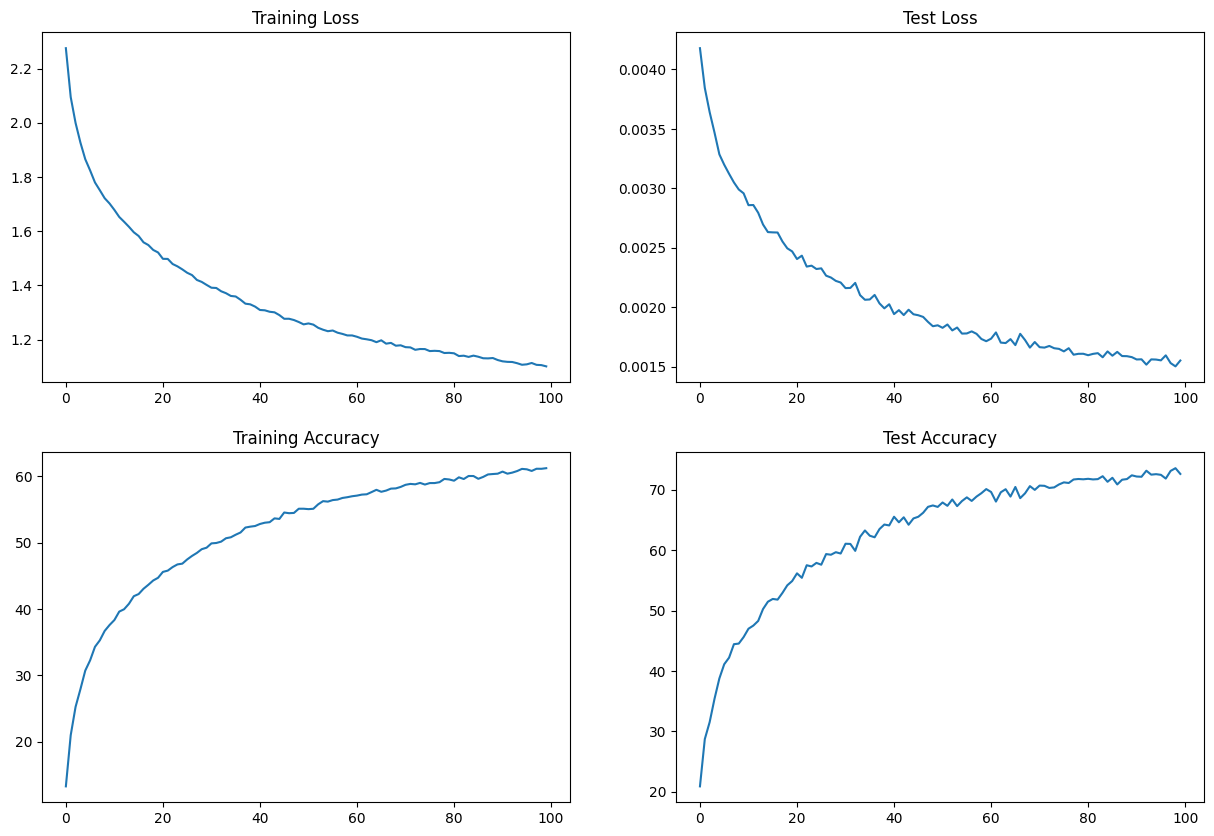

In [14]:
plot_acc_loss()

In [ ]:
layers = [
    {'kernel_size': 3, 'stride': 1, 'dilation': 1},  # convblock1 starts
    {'kernel_size': 3, 'stride': 1, 'dilation': 1},
    {'kernel_size': 3, 'stride': 1, 'dilation': 1},
    {'kernel_size': 3, 'stride': 1, 'dilation': 2},
    {'kernel_size': 3, 'stride': 2, 'dilation': 1},  # convblock1 ends, convblock2 starts
    {'kernel_size': 3, 'stride': 1, 'dilation': 1},
    {'kernel_size': 3, 'stride': 1, 'dilation': 1},
    {'kernel_size': 3, 'stride': 1, 'dilation': 4},
    {'kernel_size': 3, 'stride': 2, 'dilation': 1},  # convblock2 ends, convblock3 starts
    {'kernel_size': 3, 'stride': 1, 'dilation': 1},
    {'kernel_size': 3, 'stride': 1, 'dilation': 1},
    {'kernel_size': 3, 'stride': 1, 'dilation': 2},
    {'kernel_size': 3, 'stride': 2, 'dilation': 1},  # convblock3 ends, convblock4 starts
    {'kernel_size': 3, 'stride': 1, 'dilation': 1},
    {'kernel_size': 3, 'stride': 1, 'dilation': 1},
    {'kernel_size': 3, 'stride': 1, 'dilation': 2},
    {'kernel_size': 3, 'stride': 1, 'dilation': 1}  # convblock4 ends
]

rf = 1  # Initial receptive field
jump = 1

for layer in layers:
    rf = rf + ((layer['kernel_size'] - 1) * layer['dilation']) * jump
    jump *= layer['stride']

print(f"Receptive Field: {rf}")
